<div align="center">
 <img alt="Deep Learning Indaba" src="https://gitlab.com/instadeep-public/grandchallenge/-/raw/master/dlindaba.jpg" />
    <h1>Grand Challenge</h1>
        <h2>Curing Leishmaniasis</h2>
    <br />
</div>

<h1> </h1>


This notebbok focuses on the evaluation of an arbitrary structure formed by a Leishmania protein (either from a defined species, or a protein present in the proteome of one or more of the Leishmania species) and a small molecule (ligand) which comes from a set of approved drugs.


Authors : Dr Marcin Skwark (m.skwark@instadeep.com) and Dr Nicolas Lopez Carranza (n.lopezcarranza@instadeep.com)


*This notebook is based on [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks) notebooks;
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*
In order to run it, you need to install  [PyRosetta](http://www.pyrosetta.org/dow);

In [ ]:
! conda env create -f environment.yml

*Warning*: This notebook uses `pyrosetta.distributed.viewer` code, which runs in `jupyter notebook` and might not run if you're using `jupyterlab`. Consider installing `! jupyter labextension install jupyterlab_3dmol`

In [14]:
import logging
logging.basicConfig(level=logging.INFO)
import matplotlib
%matplotlib inline
import zipfile
import os
import pandas as pd
import pyrosetta
import pyrosetta.distributed.viewer as viewer
import seaborn
seaborn.set()
import sys
import requests
working_dir = os.getcwd()
DATA_FOLDER = './data'

The pdb files describing the possible targets for the Leishmania protein are stored in a [google bucket](https://storage.googleapis.com/indaba-challenge/). A useful (but not mandatory) tool to explore the bucket is [gsutil](https://cloud.google.com/storage/docs/gsutil_install#mac). For example we can list the contents of the bucket:

In [8]:
# Example of gsutil
# List all files
# !gsutil ls -r gs://indaba-challenge/*
# Copy a file locally
# !gsutil cp gs://indaba-challenge/A0A088RHB8.0.apo.pdb .

In the bucket there is a list of approved drugs. Lets download the zip folder containing the data of all the approved drugs and extracti it locally.

In [15]:
url = 'https://storage.googleapis.com/indaba-challenge/molecules.zip'
r = requests.get(url, allow_redirects=True)
open('molecules.zip', 'wb').write(r.content)

# # Extract all the files with 
with zipfile.ZipFile('molecules.zip', 'r') as zip_ref:
    zip_ref.extractall(DATA_FOLDER)

From the bucket, lets pick as target protein `A0A088RHB8.0.apo` (88RHB8 Leishmania panamensis) and a particular drug we want to test (a.k.a ligand, compound). Lets pick [Erlotinib](https://pubchem.ncbi.nlm.nih.gov/compound/176870) `AAKJLRGGTJKAMG-UHFFFAOYSA-N`. You can search for compounds [here](https://www.ncbi.nlm.nih.gov/pccompound/?term=AAKJLRGGTJKAMG-UHFFF) and check if they are in the zip file.

In [16]:
target_protein = 'A0A088RHB8.0.apo'
target_protein_file = '{}/{}.pdb'.format(DATA_FOLDER, target_protein)

url = 'https://storage.googleapis.com/indaba-challenge/{}.pdb'.format(target_protein)
r = requests.get(url, allow_redirects=True)
open(target_protein_file, 'wb').write(r.content)



333562

In [17]:
compound = 'AAKJLRGGTJKAMG-UHFFFAOYSA-N'
ligand_params = "{}/{}.params".format(DATA_FOLDER,compound)
ligand_file = "{}/{}.pdb".format(DATA_FOLDER,compound)

Now that we have our ligand and target structure we need to create poses with rosetta and create a target-ligand pose by appending the receptor protein and the ligand (drug). The [Pose](https://www.rosettacommons.org/manuals/latest/core+protocols/d3/d3c/classcore_1_1pose_1_1_pose.html#details) class in Rosetta represents a molecular system (protein-ligand) as a container of Residues. 

We also need the [params](https://www.rosettacommons.org/docs/latest/rosetta_basics/file_types/Residue-Params-file) file for the ligand. Params files store a variety of chemical and geometric information used to define the shape and chemical connectivity of an amino acid building block or other small molecule. This will be useful to create our scoring function.

In [18]:
flags = f"""
-ignore_unrecognized_res 1
-extra_res_fa {ligand_params}
"""
pyrosetta.distributed.init(flags)
pose_ligand = pyrosetta.io.pose_from_file(filename=ligand_file)
pose = pyrosetta.io.pose_from_file(filename=target_protein_file)
pose.append_pose_by_jump(pose_ligand,pose.total_residue())

INFO:rosetta:core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OXT on residue ALA:CtermProteinFull 255
INFO:rosetta:core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  CG  on residue GLN 348
INFO:rosetta:core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  CD  on residue GLN 348
INFO:rosetta:core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OE1 on residue GLN 348
INFO:rosetta:core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  NE2 on residue GLN 348
INFO:rosetta:core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  CG  on residue GLU 385
INFO:rosetta:core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  CD  on residue GLU 385
INFO:rosetta:core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OE1 on residue GLU 385
INFO:rosetta:core.conformation.Conformation: {0} [ WARNING ] missing heavyatom:  OE2 on residue GLU 385
INFO:rosetta:core.conformation.Conformation: {0

Rosetta can be used to predict the bound structure of a ligand and a target protein starting from unbound structures. This is what we are going to do. To achieve that, we need to define a [Rosetta Ligand docking protocol](https://www.rosettacommons.org/demos/latest/tutorials/Protein-Protein-Docking/Protein-Protein-Docking). This is a script that describes the docking and scoring.

In [19]:
xml = pyrosetta.rosetta.protocols.rosetta_scripts.XmlObjects.create_from_string("""
<ROSETTASCRIPTS>
  <SCOREFXNS>
    <ScoreFunction name="fa_standard" weights="ref2015.wts"/>
  </SCOREFXNS>
  <RESIDUE_SELECTORS>
    <Chain name="chX" chains="X"/>
  </RESIDUE_SELECTORS>
  <SIMPLE_METRICS>
    <RMSDMetric name="rmsd_chX" residue_selector="chX" reference_name="store_native" residue_selector_ref="chX" robust="true" rmsd_type="rmsd_all" />
  </SIMPLE_METRICS>
  <SCORINGGRIDS ligand_chain="X" width="25">
    <ClassicGrid grid_name="vdw" weight="1.0"/>
  </SCORINGGRIDS>
  <LIGAND_AREAS>
    <LigandArea name="docking_sidechain_X" chain="X" cutoff="6.0" add_nbr_radius="true" all_atom_mode="true" minimize_ligand="10"/>
    <LigandArea name="final_sidechain_X" chain="X" cutoff="6.0" add_nbr_radius="true" all_atom_mode="true"/>
    <LigandArea name="final_backbone_X" chain="X" cutoff="7.0" add_nbr_radius="false" all_atom_mode="true" Calpha_restraints="0.3"/>
  </LIGAND_AREAS>
  <INTERFACE_BUILDERS>
    <InterfaceBuilder name="side_chain_for_docking" ligand_areas="docking_sidechain_X"/>
    <InterfaceBuilder name="side_chain_for_final" ligand_areas="final_sidechain_X"/>
    <InterfaceBuilder name="backbone" ligand_areas="final_backbone_X" extension_window="3"/>
  </INTERFACE_BUILDERS>
  <MOVEMAP_BUILDERS>
    <MoveMapBuilder name="docking" sc_interface="side_chain_for_docking" minimize_water="true"/>
    <MoveMapBuilder name="final" sc_interface="side_chain_for_final" bb_interface="backbone" minimize_water="true"/>
  </MOVEMAP_BUILDERS>
  <MOVERS>
    <SavePoseMover name="spm" restore_pose="0" reference_name="store_native"/>
    <Transform name="transform" chain="X" box_size="20.0" move_distance="10" angle="360" initial_perturb="2" cycles="500" repeats="5" temperature="1000"/>
    <HighResDocker name="high_res_docker" cycles="9" repack_every_Nth="3" scorefxn="fa_standard" movemap_builder="docking"/>
    <FinalMinimizer name="final" scorefxn="fa_standard" movemap_builder="final"/>
  </MOVERS>
  <FILTERS>
      <LigInterfaceEnergy name="interfE" scorefxn="fa_standard" energy_cutoff="0.0" confidence="0"/>
      <SimpleMetricFilter name="rmsd_chX" metric="rmsd_chX" cutoff="999999." comparison_type="lt" confidence="0"/>
  </FILTERS>
  <PROTOCOLS>
    <Add mover="spm"/>
    <Add mover="transform"/>
    <Add mover="high_res_docker"/>
    <Add mover="final"/>
    <Add filter="interfE"/>
    <Add filter="rmsd_chX"/>
  </PROTOCOLS>
</ROSETTASCRIPTS>
""").get_mover("ParsedProtocol")

Now we are ready to produce 5 global ligand docking trajectories (We could create as many as we like). Each of them will score differently.

In [20]:
scorefxn = pyrosetta.create_score_function("ref2015")
output_dir = "output"
os.chdir(working_dir)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
os.chdir(output_dir)

df = pd.DataFrame()
for i in range(5):
    test_pose = pose.clone()
    xml.apply(test_pose)
    test_df = pd.DataFrame.from_records(dict(test_pose.scores), index=[i])
    df = df.append(test_df)
    test_pose.dump_pdb('{}_{}.pdb'.format(target_protein, str(i)))
os.chdir(working_dir)

INFO:rosetta:protocols.ligand_docking.Transform: {0} [ WARNING ] A large number of moves were rejected for being outside the grid. You likely want to reexamine your settings.
INFO:rosetta:protocols.ligand_docking.Transform: {0} [ WARNING ]     For the current settings, a grid size of at least 99.9    and a box size of at least 260.9 are recommended.
INFO:rosetta:protocols.ligand_docking.ligand_options.FinalMinimizer: {0} [ WARNING ] Warning: FinalMinimizer with backbone minimization used without chainbreak scoreterm - setting chainbreak to 1
INFO:rosetta:protocols.ligand_docking.Transform: {0} [ WARNING ] A large number of moves were rejected for being outside the grid. You likely want to reexamine your settings.
INFO:rosetta:protocols.ligand_docking.Transform: {0} [ WARNING ]     For the current settings, a grid size of at least 99.9    and a box size of at least 260.9 are recommended.
INFO:rosetta:protocols.ligand_docking.ligand_options.FinalMinimizer: {0} [ WARNING ] Warning: FinalM

Now that we have sampled some global ligand docking trajectories, let's plot the ligand binding energy landscape. The less interface energy the better drug target we found:

<AxesSubplot:xlabel='rmsd_chX', ylabel='interfE'>

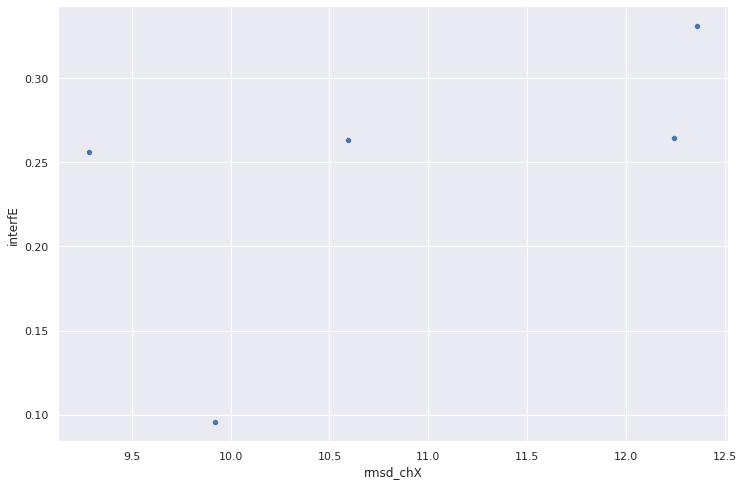

In [21]:
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
seaborn.scatterplot(x="rmsd_chX", y="interfE", data=df)

We can check which `.pdb` file has the lowest `interfE` score:

In [11]:
df.sort_values(by="interfE")

dslf_fa13       fa_atr       fa_dun     fa_elec  fa_intra_rep  \
0        0.0 -3223.690223  1549.990918 -717.032477   1286.545245   
3        0.0 -3230.922164  1510.506631 -723.913988   1283.786519   
4        0.0 -3234.536679  1569.515416 -727.247633   1297.946856   
1        0.0 -3234.491161  1542.268903 -730.531128   1286.897718   
2        0.0 -3232.835785  1545.189256 -739.266102   1290.654440   

   fa_intra_sol_xover4      fa_rep       fa_sol  hbond_bb_sc  hbond_lr_bb  \
0           110.226691  868.422655  1859.139041   -70.704694  -100.986481   
3           109.684159  866.612762  1865.523925   -69.955554  -100.895999   
4           111.850058  882.870879  1866.523686   -70.715623  -100.813283   
1           109.301480  868.392497  1865.311161   -70.888044  -100.432502   
2           107.639499  855.452272  1865.992850   -72.652926  -101.804898   

   ...    interfE  lk_ball_wtd       omega     p_aa_pp  pro_close  \
0  ...   0.125419   -75.514454  208.869378 -123.627628  51.532583   
3  ...   0.197578   -75.295800  205.502837 -126.129102  51.596564   
4  ...   0.278527   -75.223128  210.353080 -124.800536  51.507107   
1  ...   0.468906   -74.912661  206.230491 -123.529004  51.692238   
2  ...  10.775669   -77.128003  204.899754 -123.618833  51.743334   

   rama_prepro        ref   rmsd_chX  total_score  yhh_planarity  
0     0.770611  213.48252   9.579345  -608.778746       0.000644  
3     1.481499  213.48252  10.521746  -652.858482       0.000000  
4     4.466362  213.48252   9.360036  -603.968870       0.000000  
1    -0.778594  213.48252  10.477262  -640.358655       0.002328  
2     0.997950  213.48252  14.113921  -658.884013       0.012077  

[5 rows x 22 columns]

Let's take a look at the pose with the lowest `interfE` value that was generated:

In [12]:
#Skip for tests
lowest_energy_pdb_filename = './{}/{}_{}.pdb'.format(output_dir,target_protein, str(df.sort_values(by="interfE").head(1).index[0])) 
# os.path.join("output", str(df.sort_values(by="interfE").head(1).index[0]))
print(lowest_energy_pdb_filename)
test_pose = pyrosetta.io.pose_from_file(filename=lowest_energy_pdb_filename)

chE = pyrosetta.rosetta.core.select.residue_selector.ChainSelector("E")

view = viewer.init(test_pose)
view.add(viewer.setStyle())
view.add(viewer.setStyle(command=({"hetflag": True}, {"stick": {"colorscheme": "brownCarbon", "radius": 0.2}})))
view.add(viewer.setSurface(residue_selector=chE, opacity=0.7, color='white'))
view.add(viewer.setHydrogenBonds())
view()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

If you think you achieved a good candidate, upload the pdb file to [Zindi](https://zindi.africa/competitions/indaba-grand-challenge-curing-leishmaniasis). You might be curing a Neglected Tropical Disease.

*Your turn:*

Re-run the above example with more sampling and with a different receptor protein and ligand (drug).

***
*Restart Jupyter Notebook kernel to properly re-initialize PyRosetta*
***